# PSF Gaussian Fitting demo

[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/imaging/psf_fitting.ipynb)


This notebook demonstrates PSF fitting to a 2-D gaussian beam. The fitting code was adopted from https://github.com/casangi/cngi_prototype/blob/master/cngi/image/fit_gaussian.py . This demo uses a CASA PSF image and converted into an XRadio image format, then fitting is performed. Simple numerical comparison with the beam parameters stored in the input CASA image are also made.

## Install AstroVIPER

Skip this cell if you don't want to install the latest version of AstroVIPER.

In [ ]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")
    os.system("pip install python-casacore")
    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

## Download Data

Download the test CASA PSF image and convert to the XRADIO image

In [1]:
# use toolviper
import toolviper
toolviper.utils.data.update()


[2025-09-16 11:48:36,163]     INFO    viperlog:  Updating file metadata information ...  


Output()

In [2]:
from toolviper.utils.data import download
download(file="twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf")

[2025-09-16 11:48:36,346]     INFO    viperlog:  Module path: /Users/jsteeb/Dropbox/toolviper/src/toolviper 
[2025-09-16 11:48:36,349]     INFO    viperlog:  Downloading from [cloudflare] .... 


 Download List                                      
 ─────────────────────────────────────────────────── 
  twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf

Output()

## Import the data and run PSF gaussian fit 

### Import the CASA image to an XRADIO image data

In [3]:
from xradio.image import read_image
xds = read_image(infile='twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf', chunks={"l":25, "m":25, "frequency":4} )

[2025-09-16 11:48:37,914]     INFO    viperlog:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
Successful readonly open of default-locked table twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf: 1 columns, 1 rows
[2025-09-16 11:48:37,921]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


### Examine data content

In [4]:
xds.SKY

<xarray.DataArray 'SKY' (time: 1, frequency: 11, polarization: 1, l: 250, m: 250)> Size: 3MB
dask.array<transpose, shape=(1, 11, 1, 250, 250), dtype=float32, chunksize=(1, 4, 1, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 8B 5.625e+04
  * frequency        (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 88B 2.454e+03 1.964e+03 ... -2.454e+03
  * l                (l) float64 2kB 6.06e-05 6.012e-05 ... -6.012e-05
  * m                (m) float64 2kB -6.06e-05 -6.012e-05 ... 6.012e-05
    right_ascension  (l, m) float64 500kB 1.409 1.409 1.409 ... 1.409 1.409
    declination      (l, m) float64 500kB -0.6364 -0.6364 ... -0.6363 -0.6363
Attributes:
    image_type:       Intensity
    units:            
    telescope:        {'name': 'ALMA', 'direction': {'attrs': {'coordinate_sy...
    observer:         cqi
    obsdate:          {'attrs': {'units': 'd', 'scale': 'UTC', 'format': 'MJD...
    pointing_center:  {'attrs': {'frame': 'fk5', 'type': 'sky_coord', 'units'...
    object_name:      J0522-364
    user:             {'INSTRUME': 'ALMA', 'distance': 0.0, 'mpiprocs': 1, 'c...
    active_mask:      None
    description:      None
    history:          <xarray.Dataset> Size: 31kB\nDimensions:    (row: 94)\n...

In [5]:
xds.BEAM

<xarray.DataArray 'BEAM' (time: 1, frequency: 11, polarization: 1, beam_param: 3)> Size: 264B
dask.array<array, shape=(1, 11, 1, 3), dtype=float64, chunksize=(1, 11, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 8B 5.625e+04
  * frequency     (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization  (polarization) <U1 4B 'I'
    velocity      (frequency) float64 88B 2.454e+03 1.964e+03 ... -2.454e+03
  * beam_param    (beam_param) <U5 60B 'major' 'minor' 'pa'
Attributes:
    units:    rad

### Run gaussian fit on the PSF image

The psf_gaussian_fit function will create a copy of xds and add fitted beam parameters to BEAM data variable.

In [6]:
# import psf gaussian fit function
from astroviper.core.image_analysis.psf_gaussian_fit import psf_gaussian_fit
psf_gaussian_fit?

Signature:
psf_gaussian_fit(
    xds: xarray.core.dataset.Dataset,
    dv: str = 'SKY',
    npix_window: tuple = [9, 9],
    sampling: tuple = [9, 9],
    cutoff: float = 0.35,
)
Docstring:
fit 2D gaussian to psf

Parameters
----------
xds : xarray.Dataset
    The input data cube.
dv : str
    The data variable to fit. Default is 'SKY'.
npix_window : list
    The size of the fitting window in pixels.
sampling : list
    The sampling of the fitting grid in pixels.
cutoff : float
    The cutoff value for the fitting.

Returns
-------
xds : xarray.Dataset
    The image with the fitted parameters added.
    The unit of beam size (major and minor) will be the same unit as
    that of the input image's (l,m) coordintes, which assumed to be
    radian. The position angle is given in degrees.
File:      ~/miniforge3/envs/zinc/lib/python3.13/site-packages/astroviper/core/image_analysis/psf_gaussian_fit.py
Type:      function

In [7]:
# run psf fitting 
res_xds = psf_gaussian_fit(xds,npix_window=(21,21), sampling=(21,21))

/Users/jsteeb/miniforge3/envs/zinc/lib/python3.13/site-packages/astroviper/core/image_analysis/psf_gaussian_fit.py:176: NumbaWarning: Code running in object mode won't allow parallel execution despite nogil=True.
  with objmode(res_x="f8[:]"):  # return type annotation


##　Results

In [8]:
# the fitted beam parameters (Bmaj, Bmin, PA) are stored in radians in BEAM data variable 
res_xds['BEAM'].compute()

<xarray.DataArray 'BEAM' (time: 1, frequency: 11, polarization: 1, beam_param: 3)> Size: 264B
array([[[[2.62084978e-06, 2.13174238e-06, 5.58018284e-01]],

        [[2.59468965e-06, 2.08456338e-06, 5.90873874e-01]],

        [[2.59468697e-06, 2.08456088e-06, 5.90874385e-01]],

        [[2.59468110e-06, 2.08455815e-06, 5.90873179e-01]],

        [[2.59494104e-06, 2.08421000e-06, 5.90726781e-01]],

        [[2.59493766e-06, 2.08420569e-06, 5.90724487e-01]],

        [[2.59493308e-06, 2.08419995e-06, 5.90722693e-01]],

        [[2.59492998e-06, 2.08419436e-06, 5.90721997e-01]],

        [[2.59492668e-06, 2.08419050e-06, 5.90721603e-01]],

        [[2.59492477e-06, 2.08418847e-06, 5.90721273e-01]],

        [[2.59492143e-06, 2.08418610e-06, 5.90724582e-01]]]])
Coordinates:
  * time          (time) float64 8B 5.625e+04
  * frequency     (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization  (polarization) <U1 4B 'I'
    velocity      (frequency) float64 88B 2.454e+03 1.964e+03 ... -2.454e+03
  * beam_param    (beam_param) <U5 60B 'major' 'minor' 'pa'
Attributes:
    units:    rad

### Plot the input image with the original CASA beam stored in the image for reference

In [9]:
# select first frequency channel
data_sel = {'time':[0], 'polarization':[0], 'frequency':[0]}

CASA beam parameters: bmaj=2.6214203167700385e-06,bmin=2.1205892648113387e-06, bpa=30.86190414428711


'rad'

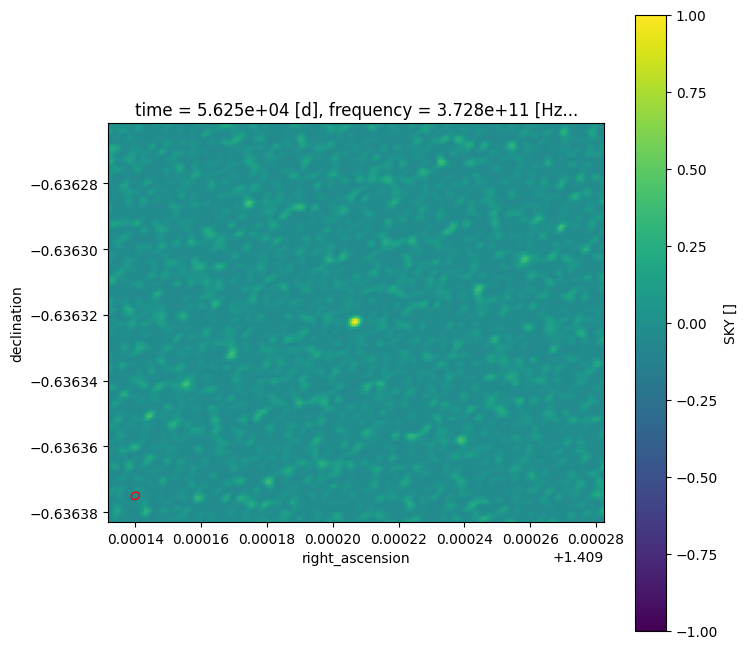

In [10]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

data1 = xds.SKY.isel(data_sel).squeeze().T
#
fig, ax = plt.subplots(figsize=(8,8))
data1.plot.pcolormesh(x='right_ascension', y='declination', ax=ax, cmap='viridis', add_colorbar=True)
bmaj = xds.BEAM.isel(data_sel).data.compute()[0,0,0][0]
bmin = xds.BEAM.isel(data_sel).data.compute()[0,0,0][1]
bpa = np.rad2deg(xds.BEAM.isel(data_sel).data.compute()[0,0,0][2])
print(f'CASA beam parameters: bmaj={bmaj},bmin={bmin}, bpa={bpa}')
from matplotlib.patches import Ellipse

beam = Ellipse(
    (1.40914,-0.636375),
    width=bmaj,
    height=bmin,
    angle=bpa,
    color='red',
    lw=1,
    fill=False,
    zorder=10 # Ensure the ellipse is drawn on top
)
ax.add_patch(beam)
ax.set_aspect('equal', adjustable='box')
xds.BEAM.attrs['units']

### Compare the fitting result with one provided in the input image

In [11]:
# Generate 2D gaussian using xds BEAM data variable 
def psf_model(xds, data_sel, beam_param):
    wx, wy, rot = beam_param
    #print(f"bmaj:{wx}, bmin:{wy}, pa:{rot}")
    l = xds.SKY.isel(data_sel).l.data
    m = xds.SKY.isel(data_sel).m.data
    X, Y = np.meshgrid(l,m)
    # adjust rotation angle to one measured from +x axis
    rot = -(np.pi/2 - rot)
    xp = X*np.cos(rot) + Y*np.sin(rot)
    yp = X*np.sin(rot) - Y*np.cos(rot)
    gaussian = 1.0 * np.exp(-(((xp) / wx) ** 2 + ((yp) / wy) ** 2) / 2.0)
    return gaussian

In [12]:
casa_model = psf_model(xds, data_sel, xds.BEAM.isel(data_sel).data.compute().squeeze())

In [13]:
# new fit result
model = psf_model(xds, data_sel,res_xds.BEAM.isel(data_sel).data.compute().squeeze())

In [14]:
# extract beam parameters (without data selection)
beam_param = res_xds.BEAM.data.compute()
bmajs = beam_param[:,:,:].squeeze().T[0]
bmins = beam_param[:,:,:].squeeze().T[1]
pas = beam_param[:,:,:].squeeze().T[2]
casa_beam_param = xds.BEAM.data.compute()
casa_bmajs = casa_beam_param[:,:,:].squeeze().T[0]
casa_bmins = casa_beam_param[:,:,:].squeeze().T[1]
casa_pas = casa_beam_param[:,:,:].squeeze().T[2]

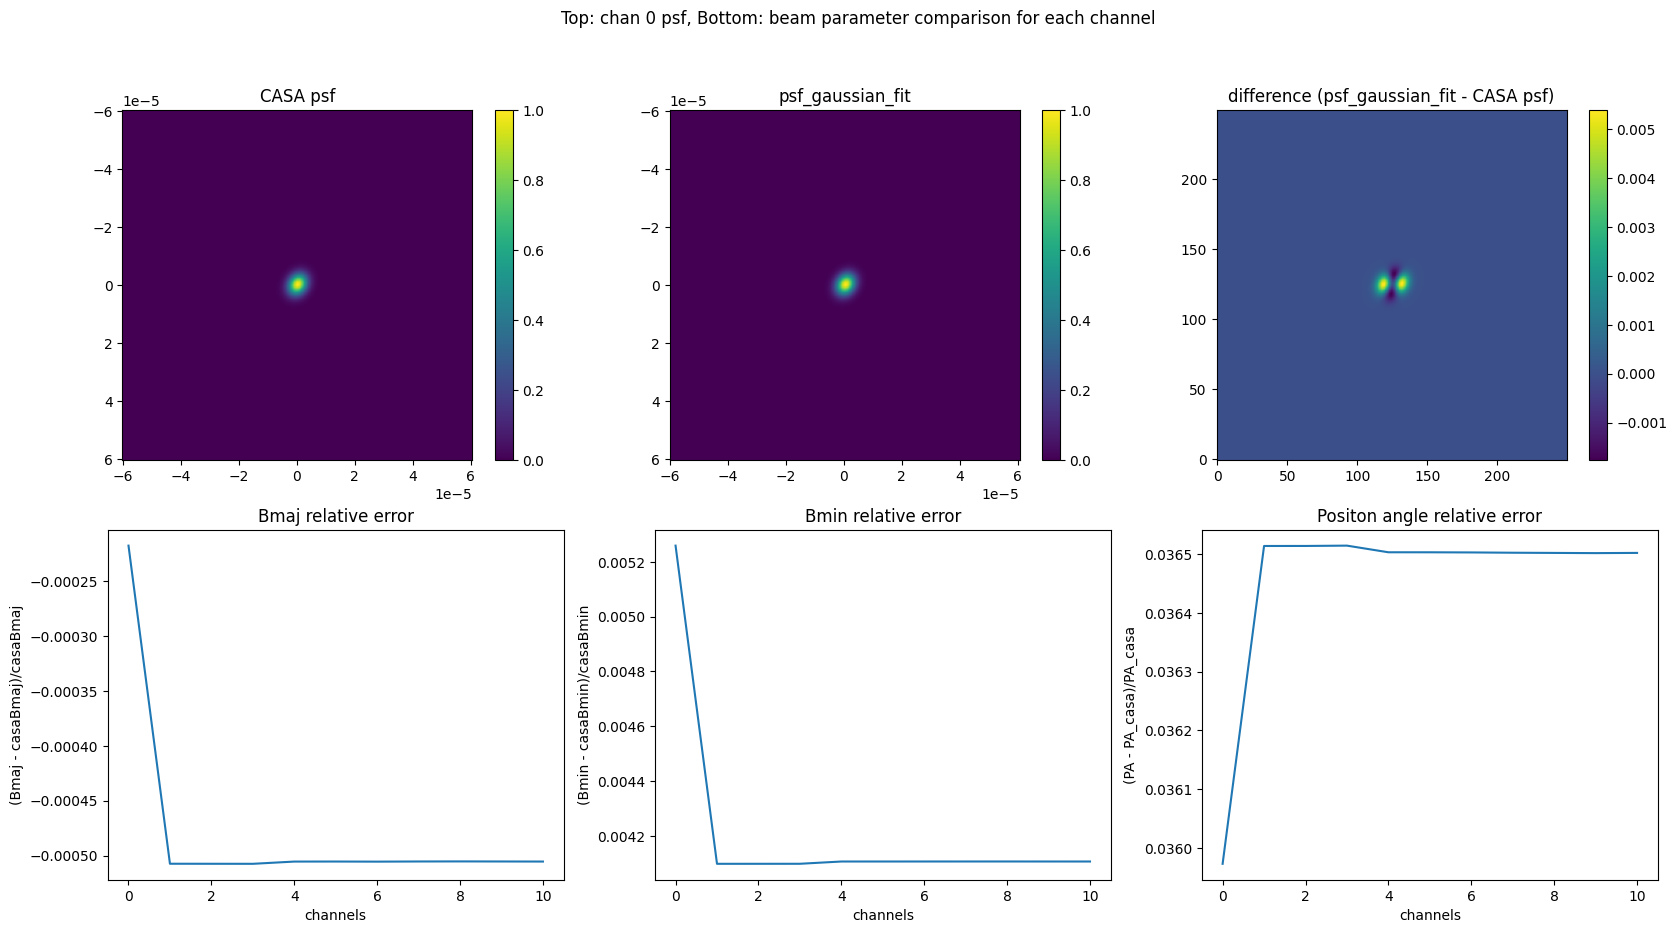

In [15]:
# plot beam images
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
l = xds.SKY.isel(data_sel).l.data
m = xds.SKY.isel(data_sel).m.data
extent=(l[-1], l[0], m[-1], m[0])
im1 = axes[0, 0].imshow(casa_model, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(im1, ax=axes[0,0])
axes[0, 0].set_title("CASA psf")
im2 = axes[0, 1].imshow(model, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(im2, ax=axes[0,1])
axes[0,1].set_title("psf_gaussian_fit")
im3 = axes[0,2].imshow( (model - casa_model), origin='lower', cmap='viridis')
axes[0,2].set_title("difference (psf_gaussian_fit - CASA psf)")
plt.colorbar(im3, ax=axes[0,2])
# plot beam parameters across channels
chans = np.arange(beam_param.shape[1])
axes[1,0].plot(chans, (bmajs - casa_bmajs)/bmaj)
axes[1,0].set_ylabel("(Bmaj - casaBmaj)/casaBmaj")
axes[1,0].set_xlabel("channels")
axes[1,0].set_title("Bmaj relative error")
axes[1,1].plot(chans, (bmins - casa_bmins)/casa_bmins)
axes[1,1].set_ylabel("(Bmin - casaBmin)/casaBmin")
axes[1,1].set_xlabel("channels")
axes[1,1].set_title("Bmin relative error")
#axes[1,2].plot(chans, (pas - casa_pas)/casa_pas)
axes[1,2].set_ylabel("(PA - PA_casa)/PA_casa")
axes[1,2].set_xlabel("channels")
axes[1,2].set_title("Positon angle relative error")
axes[1,2].plot(chans, (pas - casa_pas)/casa_pas)
fig.suptitle("Top: chan 0 psf, Bottom: beam parameter comparison for each channel")
plt.show()